In [1]:
import pandas as pd
import re
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

In [2]:
# Función para convertir DMS a Decimal
# ================================
def dms_to_decimal(coord):
    match = re.match(r"(\d+)°(\d+)'([\d\.]+)\" ([NSEW])", str(coord))
    if not match:
        return None
    
    grados = int(match.group(1))
    minutos = int(match.group(2))
    segundos = float(match.group(3))
    direccion = match.group(4)
    
    decimal = grados + minutos/60 + segundos/3600
    
    if direccion in ["S", "W"]:
        decimal = -decimal
    
    return decimal

In [3]:
# leer archivo data/graproes.xlsx
censo = pd.read_excel("data/graproes.xlsx")

# Convertir columnas de coordenadas
censo["LAT_DECIMAL"] = censo["LATITUD"].apply(dms_to_decimal)
censo["LON_DECIMAL"] = censo["LONGITUD"].apply(dms_to_decimal)

# Filtrar columnas necesarias
censo = censo[["NOM_LOC", "LAT_DECIMAL", "LON_DECIMAL", "GRAPROES"]].dropna()

print(censo.head())

                                         NOM_LOC  LAT_DECIMAL  LON_DECIMAL  \
0  Francisco I. Madero (San Isidro Calabacillas)    28.758006  -106.301104   
1                               Abraham González    28.390926  -105.726403   
2                           Rancho los Aguilares    28.149711  -106.210924   
3                                    El Alamillo    28.260899  -106.192828   
4                             Rancho el Alamillo    28.141408  -106.234349   

   GRAPROES  
0      6.36  
1      7.20  
2      5.97  
3      4.51  
4      6.37  


In [4]:
# leer archivo 'data/IPH_robos_ene-ago-2025_tecmty.xlsx'
df = pd.read_excel("data/IPH_robos_ene-ago-2025_tecmty.xlsx")

# Asegurar que las columnas sean numéricas
df["LATITUD"] = pd.to_numeric(df["LATITUD"], errors="coerce")
df["LONGITUD"] = pd.to_numeric(df["LONGITUD"], errors="coerce")

df = df.dropna(subset=["LATITUD", "LONGITUD"])

# cambiar de nombre a las columnas
df = df.rename(columns={"LATITUD": "LAT_DECIMAL", "LONGITUD": "LON_DECIMAL"})

print(df.head())

    FOLIO      FECHA  HORA  MINUTO                    TIPO VOLENCIA  \
0  759476 2025-01-01     5      11          ROBO A NEGOCIO       SI   
1  759978 2025-01-01     5      25          ROBO A NEGOCIO       SI   
2  760050 2025-01-01     6      31        ROBO DE VEHICULO       NO   
3  760404 2025-01-01    11      50  ROBO A CASA HABITACION       NO   
4  769412 2025-01-01    12       0          ROBO A NEGOCIO       NO   

   LAT_DECIMAL  LON_DECIMAL DISTRITO  CUADRANTE  
0    28.600113  -106.061258   Zapata         76  
1    28.609652  -106.065990   Zapata         75  
2    28.639322  -106.039862  Morelos         51  
3    28.643275  -106.030795  Morelos         51  
4    28.693501  -106.115590    Villa         17  


In [ ]:
# Cruzar con k-NN (1 vecino más cercano)
# ================================
# Modelo Nearest Neighbors
nn = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(censo[["LAT_DECIMAL", "LON_DECIMAL"]])

distancias, indices = nn.kneighbors(df[["LAT_DECIMAL", "LON_DECIMAL"]])

# Asignar GRAPROES a cada registro de robos
df["GRAPROES"] = censo.iloc[indices.flatten()]["GRAPROES"].values
df["NOM_LOC"] = censo.iloc[indices.flatten()]["NOM_LOC"].values

In [6]:
# Vista previa
# ================================
print("Vista previa de la base enriquecida:")
df.head(10)

Vista previa de la base enriquecida:


,FOLIO,FECHA,HORA,MINUTO,TIPO,VOLENCIA,LAT_DECIMAL,LON_DECIMAL,DISTRITO,CUADRANTE,GRAPROES,NOM_LOC
0,759476,2025-01-01,5,11,ROBO A NEGOCIO,SI,28.600113,-106.061258,Zapata,76,8.13,Las Casas
1,759978,2025-01-01,5,25,ROBO A NEGOCIO,SI,28.609652,-106.065990,Zapata,75,8.13,Las Casas
2,760050,2025-01-01,6,31,ROBO DE VEHICULO,NO,28.639322,-106.039862,Morelos,51,9.15,Los Pericos
3,760404,2025-01-01,11,50,ROBO A CASA HABITACION,NO,28.643275,-106.030795,Morelos,51,9.15,Los Pericos
4,769412,2025-01-01,12,0,ROBO A NEGOCIO,NO,28.693501,-106.115590,Villa,17,12.13,Bloquera Muruato
5,760412,2025-01-01,12,6,ROBO A NEGOCIO,NO,28.693475,-106.115476,Villa,17,12.13,Bloquera Muruato
6,760559,2025-01-01,13,47,ROBO DE VEHICULO,NO,28.771511,-106.161973,Colón,3,8.19,Colonia Agrícola Francisco Villa
7,761131,2025-01-01,19,10,ROBO A CASA HABITACION,NO,28.662759,-105.948717,Morelos,48,8.57,Santa Lucía
8,762249,2025-01-02,9,10,ROBO DE VEHICULO,NO,28.587403,-106.040247,Morelos,59,7.40,Colonia la Paz
9,762311,2025-01-02,9,42,ROBO A NEGOCIO,NO,28.631906,-106.121163,Diana,32,6.57,Los Fernández


In [7]:
# Análisis de clusters con GRAPROES

# Seleccionamos variables numéricas para clustering
X = df[["LAT_DECIMAL", "LON_DECIMAL", "GRAPROES"]]

# Definir número de clusters (ejemplo: 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

print("\nDistribución de registros por cluster:")
print(df["Cluster"].value_counts())


Distribución de registros por cluster:
Cluster
0    629
1    289
2    181
Name: count, dtype: int64


In [10]:
df.TIPO.value_counts()

TIPO
ROBO A NEGOCIO            659
ROBO A CASA HABITACION    241
ROBO DE VEHICULO          199
Name: count, dtype: int64

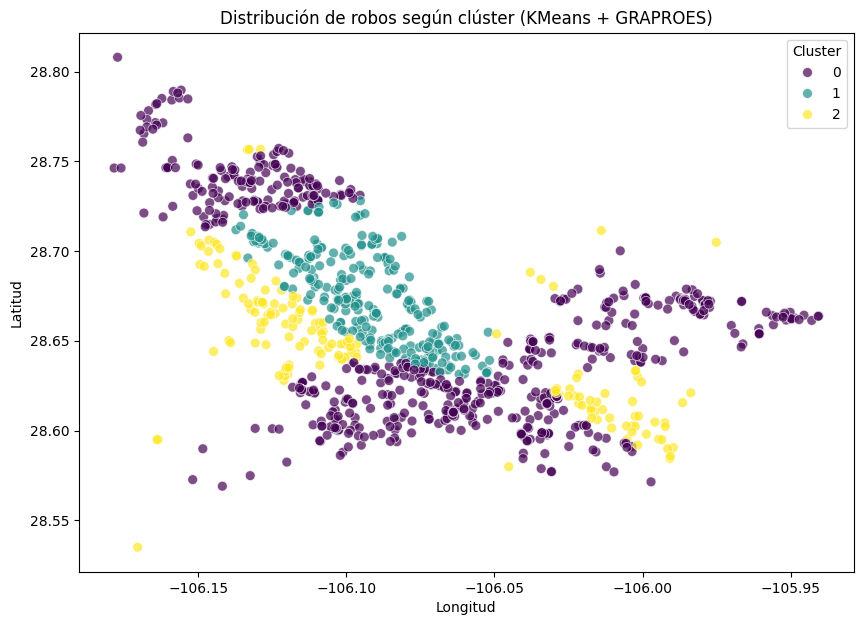

In [9]:
# Visualización 1: Scatter Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df,
    x="LON_DECIMAL", y="LAT_DECIMAL",
    hue="Cluster",
    palette="viridis",
    s=50, alpha=0.7
)
plt.title("Distribución de robos según clúster (KMeans + GRAPROES)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(title="Cluster")
plt.show()

In [11]:
import folium
from folium.plugins import HeatMap

# ================================
# 1. Crear el mapa base de Chihuahua
# ================================
# Centro aproximado de la ciudad de Chihuahua
centro_chihuahua = [28.6353, -106.0889]

# Crear mapa base
m = folium.Map(location=centro_chihuahua, zoom_start=12, tiles="CartoDB positron")

In [12]:
# ================================
# 2. Mapa de calor (densidad de robos)
# ================================
# Convertimos a lista de coordenadas
heat_data = df[["LAT_DECIMAL", "LON_DECIMAL"]].dropna().values.tolist()

# Agregar capa de calor
HeatMap(heat_data, radius=10, blur=15, min_opacity=0.4).add_to(m)

In [13]:
# ================================
# 3. Agregar puntos por cluster (opcional)
# ================================
# Si ya hiciste clustering, puedes añadirlo así:
if "GRAPROES" in df.columns:
    for _, row in df.sample(200).iterrows():  # mostramos 200 puntos para no saturar
        folium.CircleMarker(
            location=[row["LAT_DECIMAL"], row["LON_DECIMAL"]],
            radius=3,
            color="blue",
            fill=True,
            fill_opacity=0.6,
            popup=f"GRAPROES: {row['GRAPROES']}<br>Loc: {row['NOM_LOC']}"
        ).add_to(m)

In [14]:
# ================================
# 4. Mostrar mapa
# ================================
m